In [1878]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.ardl import ARDL
from sklearn.model_selection import TimeSeriesSplit

In [1879]:
goods_df = pd.read_csv("../data/global_commodity_prices.csv")
goods_df["Date"] = pd.to_datetime(goods_df["Date"], errors="coerce", format="%m/%Y")
goods_df["Date"] = pd.PeriodIndex(goods_df["Date"], freq="M")

In [1880]:
X = sm.add_constant(goods_df[["Tea", "Sugar"]])
Y = goods_df["Coffee"]

model = sm.OLS(Y, X).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for Tea: {model.params["Tea"]}")
print(f"Coefficient for Sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     336.3
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           7.49e-88
Time:                        19:49:28   Log-Likelihood:                -189.31
No. Observations:                 422   AIC:                             384.6
Df Residuals:                     419   BIC:                             396.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.079      0.313      0.7

In [1881]:
brl_df = pd.read_csv("../data/brl_data_clean.csv")
vnd_df = pd.read_csv("../data/vnd_data_clean.csv")
cop_df = pd.read_csv("../data/cop_data_clean.csv")
idr_df = pd.read_csv("../data/idr_data_clean.csv")
hnl_df = pd.read_csv("../data/hnl_data_clean.csv")

xr_df = brl_df
for df in [vnd_df, cop_df, idr_df, hnl_df]:
    xr_df = pd.merge(xr_df, df, on="Date", how="inner")

xr_df["Date"] = pd.to_datetime(xr_df["Date"], errors="coerce", format="%m/%Y")
xr_df["Date"] = pd.PeriodIndex(xr_df["Date"], freq="M")

In [1882]:
merge_df = pd.merge(goods_df, xr_df, on="Date", how="inner")
merge_df

,Date,Coffee,Milk,Sugar,Tea,brl Exchange Rate,vnd Exchange Rate,cop Exchange Rate,idr Exchange Rate,hnl Exchange Rate
0,1990-01,0.758300,NaN,0.142000,1.147273,0.000006,5479.329529,440.08,1804.850000,2.0000
1,1990-02,0.840100,NaN,0.146500,0.958396,0.000010,5479.329529,451.72,1809.870000,2.0000
2,1990-03,0.939600,NaN,0.153100,0.873620,0.000016,5479.329529,463.40,1820.350000,4.0000
3,1990-04,0.937300,NaN,0.152400,0.883644,0.000021,5479.329529,474.62,1826.050000,4.0000
4,1990-05,0.920200,NaN,0.146200,0.848309,0.000023,5563.430866,485.99,1831.400000,4.2000
...,...,...,...,...,...,...,...,...,...,...
414,2024-07,2.570987,0.242129,0.193517,1.363518,5.541448,24251.560000,4036.80,16261.652826,24.8582
415,2024-08,2.614377,0.244700,0.184195,1.467152,5.552014,24245.850000,4062.98,15793.181818,24.8826
416,2024-09,2.787605,0.251466,0.206248,1.572990,5.540967,24163.540000,4191.86,15341.250000,24.8381
417,2024-10,2.767774,0.238592,0.223552,1.490232,5.623509,24192.520000,4257.76,15541.347826,24.9661


In [1883]:
Z = sm.add_constant(merge_df[["Tea", "Sugar", "brl Exchange Rate", "vnd Exchange Rate", "cop Exchange Rate", 
                              "idr Exchange Rate", "hnl Exchange Rate"]])
W = merge_df["Coffee"]

model = sm.OLS(W, Z).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for tea (PTEAUSDM): {model.params["Tea"]}")
print(f"Coefficient for sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"Coefficient for Brazil Exchange Rate: {model.params["brl Exchange Rate"]}")
print(f"Coefficient for Vietnam Exchange Rate: {model.params["vnd Exchange Rate"]}")
print(f"Coefficient for Colombia Exchange Rate: {model.params["cop Exchange Rate"]}")
print(f"Coefficient for Indonesia Exchange Rate: {model.params["idr Exchange Rate"]}")
print(f"Coefficient for Honduras Exchange Rate: {model.params["hnl Exchange Rate"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     138.7
Date:                Mon, 10 Mar 2025   Prob (F-statistic):          4.69e-104
Time:                        19:49:29   Log-Likelihood:                -114.01
No. Observations:                 419   AIC:                             244.0
Df Residuals:                     411   BIC:                             276.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2090      0.09

In [1884]:
result = adfuller(merge_df["Coffee"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037924831735
P-Value: 0.3863836197218491


In [1885]:
merge_df["coffee_diff"] = merge_df["Coffee"].diff()

merge_df["coffee_diff"] = merge_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

merge_df = merge_df.dropna(subset=["coffee_diff"])

In [1886]:
result = adfuller(merge_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397836792
P-Value: 2.877944863970424e-21


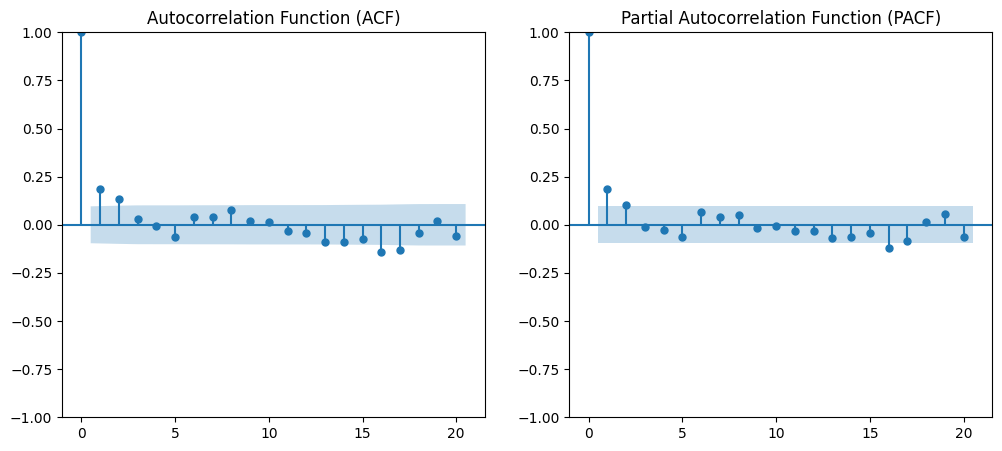

In [1887]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(merge_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(merge_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

<div align="center">
  ARMA(1,1) Model
</div>

In [1888]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()
print(fitted_model.summary())

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            coffee_diff   No. Observations:                  418
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 338.275
Date:                Mon, 10 Mar 2025   AIC                           -670.551
Time:                        19:49:29   BIC                           -658.451
Sample:                             0   HQIC                          -665.767
                                - 418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.027      7.287      0.000       0.142       0.246
ma.L1         -0.9999      0.570     -1.755      0.079      -2.116       0.117
sigma2         0.0114      0.006      1.761      0.0

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\826739681.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq="M"), forecast, label="Forecast")


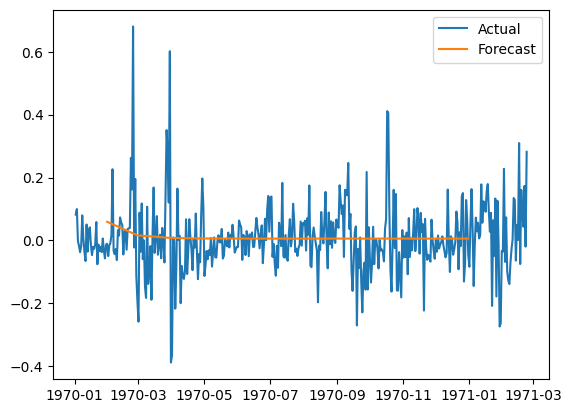

In [1889]:
forecast = fitted_model.forecast(steps=12)
plt.plot(merge_df.index, merge_df["coffee_diff"], label="Actual")
plt.plot(pd.date_range(df.index[-1], periods=12, freq="M"), forecast, label="Forecast")
plt.legend()
plt.show()

In [1890]:
mse = mean_squared_error(merge_df["coffee_diff"][-12:], forecast)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.02073472662534717


<div align="center">
  GARCH(1,1) Model
</div>

In [1891]:
returns = merge_df['coffee_diff'].dropna()

garch_model = arch_model(merge_df['coffee_diff'].dropna(), vol='Garch', p=1, q=1)

garch_result = garch_model.fit()

print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            coffee_diff   R-squared:     

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


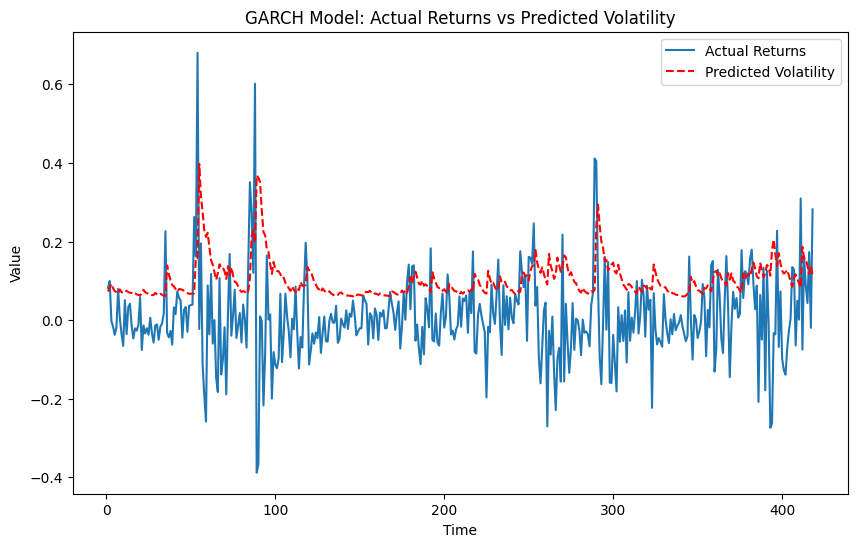

In [1892]:
predicted_volatility = garch_result.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(merge_df['coffee_diff'].dropna(), label='Actual Returns')
plt.plot(predicted_volatility, label='Predicted Volatility', color='red', linestyle='--')
plt.legend()
plt.title('GARCH Model: Actual Returns vs Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [1893]:
mse = np.mean((returns - predicted_volatility) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.02422042701650273


<div align="center">
  GARCH-M(1,1) Model
</div>

In [1894]:
returns = merge_df['coffee_diff'].dropna()

garch_m_model = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant')
garch_m_result = garch_m_model.fit()

print(garch_m_result.summary())

predicted_volatility = garch_m_result.conditional_volatility

mu = garch_m_result.params['mu']
omega = garch_m_result.params['omega']
alpha = garch_m_result.params['alpha[1]']
beta = garch_m_result.params['beta[1]']

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            coffee_diff   R-squared:     

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


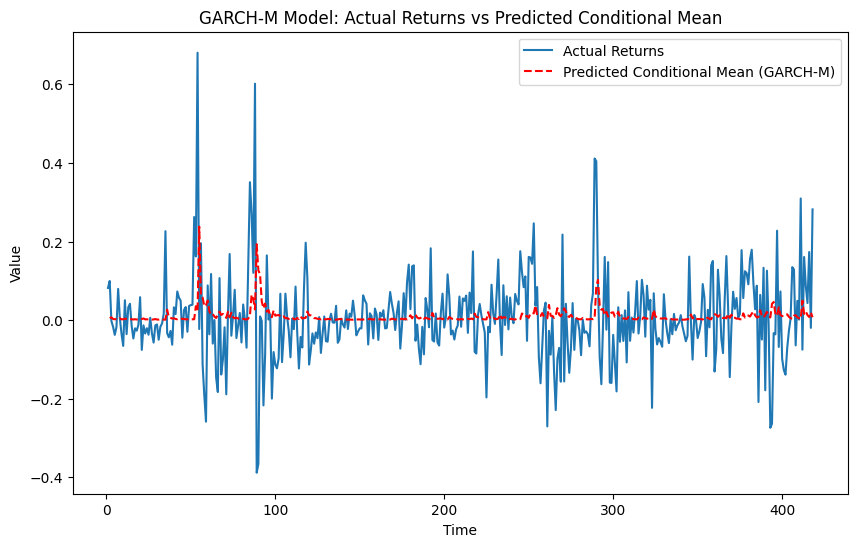

In [1895]:
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Actual Returns')
plt.plot(conditional_mean, label='Predicted Conditional Mean (GARCH-M)', color='red', linestyle='--')
plt.legend()
plt.title('GARCH-M Model: Actual Returns vs Predicted Conditional Mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [1896]:
conditional_mean = mu + alpha * returns.shift(1)**2 + beta * predicted_volatility**2

mse = np.mean((returns - conditional_mean) ** 2)
print(f'Mean Squared Error (MSE) of the GARCH-M Model: {mse}')

Mean Squared Error (MSE) of the GARCH-M Model: 0.012609165962833754


<div align="center">
  ARDL(1,1) Model
</div>

In [1897]:
merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
merge_df["tea_diff"].dropna(inplace=True)

merge_df["sugar_diff"] = merge_df["Sugar"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["brl_diff"] = merge_df["brl Exchange Rate"].diff().dropna()
merge_df["brl_diff"].dropna(inplace=True)

merge_df["vnd_diff"] = merge_df["vnd Exchange Rate"].diff().dropna()
merge_df["vnd_diff"].dropna(inplace=True)

merge_df["cop_diff"] = merge_df["cop Exchange Rate"].diff().dropna()
merge_df["cop_diff"].dropna(inplace=True)

merge_df["idr_diff"] = merge_df["idr Exchange Rate"].diff().dropna()
merge_df["idr_diff"].dropna(inplace=True)

merge_df["hnl_diff"] = merge_df["hnl Exchange Rate"].diff().dropna()
merge_df["hnl_diff"].dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\492920253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\492920253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"].dropna(inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\492920253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [1898]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]].dropna()

In [1899]:
y = y.dropna()
X = X.dropna()

y, X = y.align(X, join="inner")

y.index = pd.to_datetime(y.index)
X.index = pd.to_datetime(X.index)

model = ARDL(y, lags=(1), exog=X, order=(1, 0))
model_fitted = model.fit()

print(model_fitted.summary())

                                   ARDL Model Results                                   
Dep. Variable:                      coffee_diff   No. Observations:                  417
Model:             ARDL(1, 1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 350.765
Method:                         Conditional MLE   S.D. of innovations              0.104
Date:                          Mon, 10 Mar 2025   AIC                           -667.530
Time:                                  19:49:30   BIC                           -599.008
Sample:                              01-01-1970   HQIC                          -640.436
                                   - 01-01-1970                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0038      0.006      0.596      0.551      -0.009       0.016
coffee_diff.L1     0.1914      0.049   

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


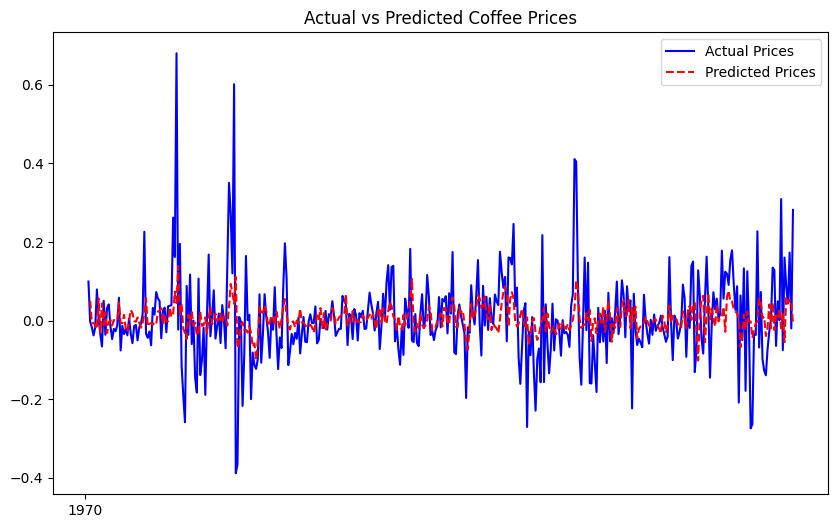

In [1900]:
plt.figure(figsize=(10, 6))
plt.plot(y, label="Actual Prices", color="blue")
plt.plot(model_fitted.fittedvalues, label="Predicted Prices", color="red", linestyle="--")
plt.title("Actual vs Predicted Coffee Prices")
plt.legend()
plt.show()

In [1901]:
y_actual = y.loc[model_fitted.fittedvalues.index]

mse = mean_squared_error(y_actual, model_fitted.fittedvalues)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.010842885610118704


<div align="center">
  GARCH(1,1) Model Forecasting
</div>

In [1902]:
target = "coffee_diff"
features = ["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
            "idr_diff", "hnl_diff"]

data = merge_df[[target] + features].dropna()
returns = data[target].dropna()

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_scores = []
predictions = []

for train_index, test_index in tscv.split(returns[:-36]):
    train_data, test_data = returns.iloc[train_index], returns.iloc[test_index]
    
    garch_model = arch_model(train_data, vol="Garch", p=1, q=1, mean="AR", lags=1)
    garch_result = garch_model.fit(disp="off")
    
    forecast = garch_result.forecast(horizon=len(test_data))
    
    predicted_returns = forecast.mean.iloc[-len(test_data):].values.flatten()
    
    if len(predicted_returns) == len(test_data):
        predictions.append(predicted_returns)
        mse = mean_squared_error(test_data, predicted_returns)
        mse_scores.append(mse)
    else:
        print(f"Skipping iteration: Predicted shape {predicted_returns.shape}, Expected {test_data.shape}")

train_data, test_data = returns[:-36], returns[-36:]
garch_model = arch_model(train_data, vol="Garch", p=1, q=1, mean="AR", lags=1)
garch_result = garch_model.fit(disp="off")

final_forecast = garch_result.forecast(horizon=36)
final_predicted_returns = final_forecast.mean.iloc[-36:].values.flatten()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01701. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\

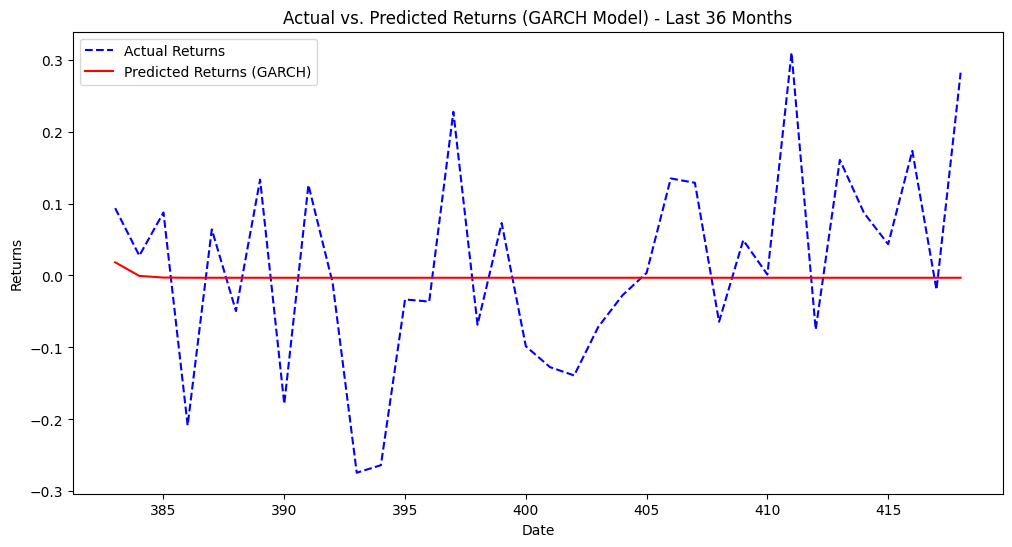

In [1903]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual Returns", color="blue", linestyle="dashed")
plt.plot(test_data.index, final_predicted_returns, label="Predicted Returns (GARCH)", color="red")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Actual vs. Predicted Returns (GARCH Model) - Last 36 Months")
plt.legend()
plt.show()

In [1904]:
if len(final_predicted_returns) == len(test_data):
    final_mse = mean_squared_error(test_data, final_predicted_returns)
else:
    final_mse = np.nan
    print(f"Final prediction shape mismatch: {final_predicted_returns.shape} vs {test_data.shape}")

print(f"Cross-validation MSE scores: {mse_scores}")
print(f"Average CV MSE: {np.mean(mse_scores)}")
print(f"Final 36-month test MSE: {final_mse}")

Cross-validation MSE scores: [0.02072107186637245, 0.0037459812812653545, 0.007292313416667802, 0.014728411077586453, 0.007225918076425791]
Average CV MSE: 0.010742739143663572
Final 36-month test MSE: 0.01888188058979482


<div align="center">
  GARCH-M(1,1) Model Forecasting
</div>

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01749. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData

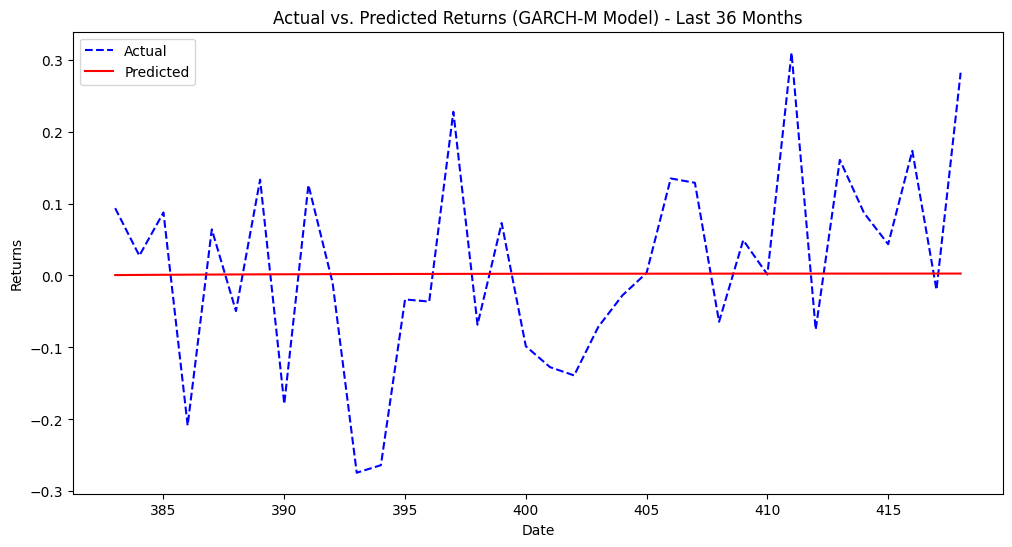

In [1905]:
target = "coffee_diff"
features = ["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
            "idr_diff", "hnl_diff"]

data = merge_df[[target] + features].dropna()
returns = data[target].dropna()

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_scores = []

for train_index, test_index in tscv.split(returns[:-36]):
    train_data, test_data = returns.iloc[train_index], returns.iloc[test_index]
    
    garch_model = arch_model(train_data, vol="Garch", p=1, q=1, mean="Constant")
    garch_result = garch_model.fit(disp="off")

    estimated_volatility = garch_result.conditional_volatility

    X = sm.add_constant(estimated_volatility)
    model = sm.OLS(train_data, X).fit()
    
    forecasted_variance = garch_result.forecast(horizon=len(test_data)).variance.iloc[-1, :]
    test_volatility = np.sqrt(forecasted_variance)

    test_X = sm.add_constant(test_volatility)
    predicted_returns = model.predict(test_X)

    mse = mean_squared_error(test_data, predicted_returns)
    mse_scores.append(mse)

train_data, test_data = returns[:-36], returns[-36:]

garch_model = arch_model(train_data, vol="Garch", p=1, q=1, mean="Constant")
garch_result = garch_model.fit(disp="off")

final_volatility = garch_result.conditional_volatility
X = sm.add_constant(final_volatility)
model = sm.OLS(train_data, X).fit()

forecasted_variance = garch_result.forecast(horizon=len(test_data)).variance.iloc[-1, :]
final_test_volatility = np.sqrt(forecasted_variance)
test_X = sm.add_constant(final_test_volatility)
final_predicted_returns = model.predict(test_X)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue", linestyle="dashed")
plt.plot(test_data.index, final_predicted_returns, label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Actual vs. Predicted Returns (GARCH-M Model) - Last 36 Months")
plt.legend()
plt.show()

In [1906]:
final_mse = mean_squared_error(test_data, final_predicted_returns)

print(f"Cross-validation MSE scores: {mse_scores}")
print(f"Average CV MSE: {np.mean(mse_scores)}")
print(f"Final 36-month test MSE: {final_mse}")

Cross-validation MSE scores: [0.02402779200964821, 0.0034521277678885407, 0.007498526290731777, 0.01500419942502582, 0.007032293667476963]
Average CV MSE: 0.011402987832154262
Final 36-month test MSE: 0.018825953065338952


<div align="center">
  ARDL(1,1) Model Forecasting
</div>

In [1907]:
target = "coffee_diff"
features = ["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
            "idr_diff", "hnl_diff"]

data = merge_df[[target] + features].dropna()
returns = data[target].dropna()

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_scores = []

for train_index, test_index in tscv.split(returns[:-36]):
    train_data, test_data = returns.iloc[train_index], returns.iloc[test_index]
    
    model = AutoReg(train_data, lags=1)
    model_fit = model.fit()

    predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    mse = mean_squared_error(test_data, predictions)
    mse_scores.append(mse)

train_data, test_data = returns[:-36], returns[-36:]
model = AutoReg(train_data, lags=1)
model_fit = model.fit()
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

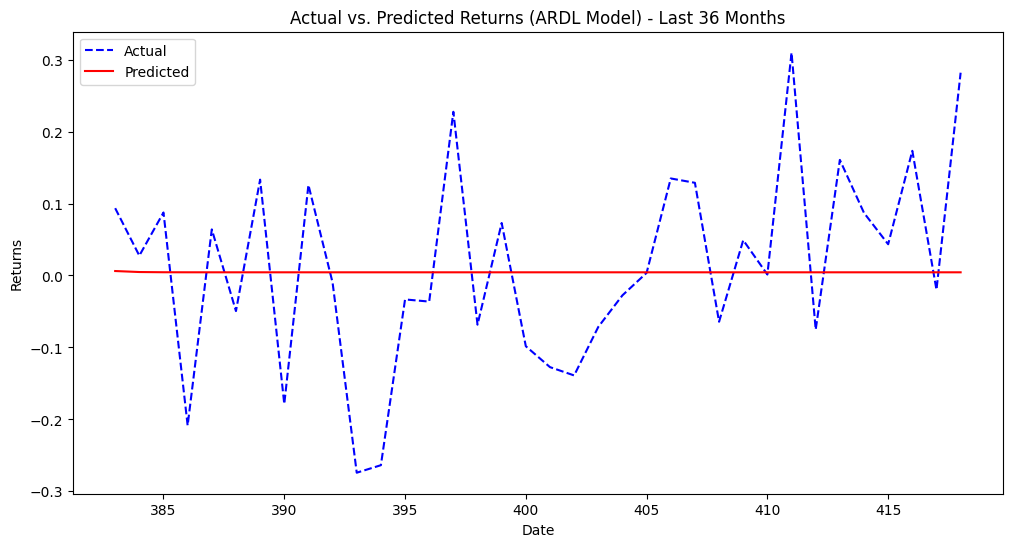

In [1908]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue", linestyle="dashed")
plt.plot(test_data.index, predictions, label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Actual vs. Predicted Returns (ARDL Model) - Last 36 Months")
plt.legend()
plt.show()

In [1909]:
final_mse = mean_squared_error(test_data, predictions)

print(f"Cross-validation MSE scores: {mse_scores}")
print(f"Average CV MSE: {np.mean(mse_scores)}")
print(f"Final 36-month test MSE: {final_mse}")

Cross-validation MSE scores: [0.02118960627721695, 0.003158405696572432, 0.006789087120779975, 0.015134899918947703, 0.006964398986280566]
Average CV MSE: 0.010647279599959526
Final 36-month test MSE: 0.018795913999644535
